# Frontal Detection Analysis (superimpose climate fields on frontal ID maps)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
file_path = "/glade/work/kdagon/FrontDetector/CESMOutputs/"

In [3]:
fronts_file = "cesm_fronts_2000-2005.nc"
onehot_file = "cesm_frontsOneHot_2000-2005.nc"
rates_file = "cesm_frontRates_2000-2005.nc"

## Read in predicted fronts file

In [4]:
pred_fronts = xr.open_dataset(file_path+fronts_file)

In [5]:
pfronts = pred_fronts.predicted_fronts

## Read in "onehot" fronts file

In [6]:
onehot = xr.open_dataset(file_path+onehot_file)

In [7]:
fronts = onehot.fronts

In [8]:
allfronts = fronts.argmax(dim='front')

In [ ]:
# average for each year
#allfronts.groupby("time.year").mean(dim="time")

## Read in sea level pressure field

In [9]:
# need to be on casper to open this folder
cesm_file_path = "/glade/campaign/cgd/ccr/kdagon/dlfront/"

In [10]:
PSL = xr.open_mfdataset(cesm_file_path+'*PSL*', combine='by_coords')

In [ ]:
SLP = PSL.PSL

## Precipitation field

In [11]:
#cesm_file_path_ne120 = "/glade/campaign/cgd/ccr/jet/nanr_forKatie/3hrly/b.e13.B20TRC5CN.ne120_g16.003/"
cesm_file_path_ne120 = "/glade/scratch/kdagon/FrontDetector/" # tmp path for chy access

In [12]:
# h4 is 3hrly instantaneous
# remapped from unstructured grid to FV (still 1/4 degree so will not completely match frontal ID)
PRECT_samp_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT.2000010100Z-2000123121Z.FV.nc"

In [13]:
PRECT = xr.open_dataset(cesm_file_path_ne120+PRECT_samp_file)

In [14]:
# subset North America to match DL-Front domain
PRECT_NA = PRECT.sel(lat=slice(10,77),lon=slice(189,329))

In [15]:
# grab a dataarray
PRECT_NA_da = PRECT_NA.PRECT
PRECT_NA_da

<xarray.DataArray 'PRECT' (time: 2920, lat: 285, lon: 448)>
[372825600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
  * time     (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

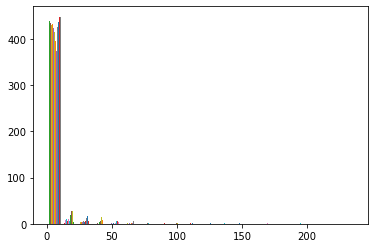

In [40]:
# quick histogram of prect values (mm/day)
plt.hist(PRECT_NA_da[0,:,:]*1000*86400, bins=20);

## Superimpose two fields

In [16]:
import matplotlib.colors 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib import cm

In [238]:
# making a custom colorbar with blue for cold, red for warm, grey for stationary, 
# purple for occluded, and white for none fronts.

cmap_all = matplotlib.colors.ListedColormap(['blue', 'red', 'grey', 'purple', 'w'])
bounds = [0, 0.99, 1.99, 2.99, 3.99, 4.99]
norm_all = matplotlib.colors.BoundaryNorm(bounds, cmap_all.N)

In [ ]:
# PSL overlay
fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())
#ax = fig.add_subplot(projection=ccrs.PlateCarree())

# start with the first time index
field, lon = add_cyclic_point(allfronts[0,:,:], coord=allfronts.lon)
lat = allfronts.lat
cf = ax.contourf(lon, lat, field, cmap=cmap_all, vmin=0, vmax=4.99, levels=bounds, transform=ccrs.PlateCarree())

field, lon = add_cyclic_point(SLP[0,:,:], coord=SLP.lon)
c = ax.contour(lon, lat, field, transform=ccrs.PlateCarree())

ax.coastlines()

import matplotlib as mpl
cbar_ax = fig.add_axes([1.05, 0.2, 0.02, 0.6])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=4.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99, 2.99, 3.99])
loc    = labels + .5
tick_1 = ['Cold','Warm','Stationary','Occluded','None']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

In [115]:
t = '2000-02-17T21' # 21 UTC = 2pm MT
tindex = PRECT_NA_da.sel(time=t)[0]
tindex

<xarray.DataArray 'PRECT' (lat: 285, lon: 448)>
[127680 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
    time     object 2000-02-17 21:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

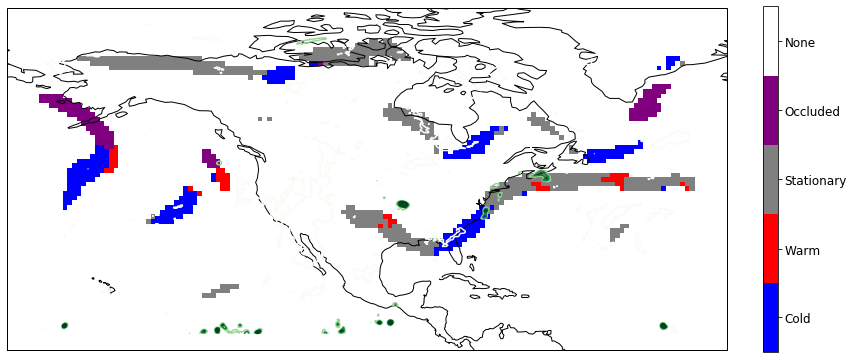

In [280]:
# PRECT overlay
fig = plt.figure(figsize=(10,8))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())

# select time index
#t = '2000-07-05T12'
t = '2000-08-21T21'

field, lon = add_cyclic_point(allfronts.sel(time=t)[0], coord=allfronts.lon)
lat = allfronts.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=4.99, norm=norm_all, transform=ccrs.PlateCarree())

pfield = PRECT_NA_da.sel(time=t)[0]*1000*86400 # convert from m/s -> mm/day
field, lon = add_cyclic_point(pfield, coord=PRECT_NA.lon)
lat = PRECT_NA.lat
c = ax.contour(lon, lat, field, cmap=cm.Greens, vmin=0, vmax=200, transform=ccrs.PlateCarree())

ax.coastlines()

import matplotlib as mpl
cbar_ax = fig.add_axes([1.05, 0.2, 0.02, 0.6])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=4.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99, 2.99, 3.99])
loc    = labels + .5
tick_1 = ['Cold','Warm','Stationary','Occluded','None']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

In [274]:
# precip colormap from unidata: https://unidata.github.io/python-gallery/examples/Precipitation_Map.html
# modified lower clevs to be less noisy
import matplotlib.colors as mcolors
clevs = [0, 4, 4.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap_prec = mcolors.ListedColormap(cmap_data, 'precipitation')
norm_prec = mcolors.BoundaryNorm(clevs, cmap_prec.N)

In [223]:
import cartopy.feature as cfeature

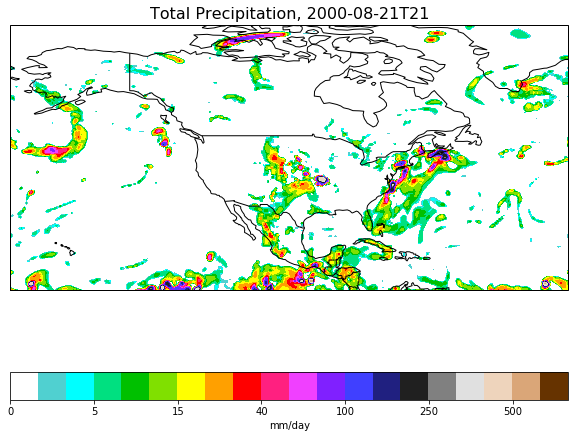

In [275]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
#ax.add_feature(cfeature.STATES)

# select time index
#t = '2000-07-05T12'
t = '2000-08-21T21'

pfield = PRECT_NA_da.sel(time=t)[0]*1000*86400 # convert from m/s -> mm/day
field, lon = add_cyclic_point(pfield, coord=PRECT_NA.lon)
lat = PRECT_NA.lat
cf = ax.contourf(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree())

# add colorbar
cbar = plt.colorbar(cf, orientation='horizontal')
cbar.set_label('mm/day')

# add title
ax.set_title('Total Precipitation, '+t, fontsize=16);

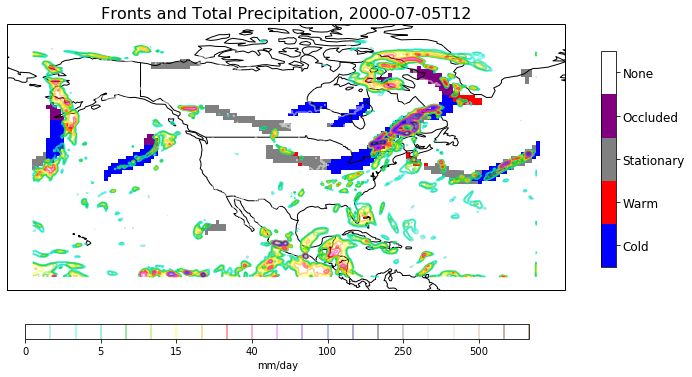

In [303]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)

# select time index
#t = '2000-07-05T12'
t = '2000-08-21T21'

field, lon = add_cyclic_point(allfronts.sel(time=t)[0], coord=allfronts.lon)
lat = allfronts.lat
cf = ax.pcolormesh(lon, lat, field, cmap=cmap_all, vmin=0, vmax=4.99, norm=norm_all, transform=ccrs.PlateCarree())

pfield = PRECT_NA_da.sel(time=t)[0]*1000*86400 # convert from m/s -> mm/day
field, lon = add_cyclic_point(pfield, coord=PRECT_NA.lon)
lat = PRECT_NA.lat
cf_prec = ax.contour(lon, lat, field, clevs, cmap=cmap_prec, norm=norm_prec, transform=ccrs.PlateCarree(), alpha=0.5)
#ax.clabel(cf_prec, inline=1, fontsize=10)

# fronts colorbar
cbar_ax = fig.add_axes([0.95, 0.35, 0.02, 0.3])
norm_all_cb = mpl.colors.Normalize(vmin=0, vmax=4.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm_all_cb,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99, 2.99, 3.99])
loc    = labels + .5
tick_1 = ['Cold','Warm','Stationary','Occluded','None']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

# prect colorbar
cbar_prec_ax = fig.add_axes([0.15, 0.25, 0.7, 0.02])
cbar_prec = plt.colorbar(cf_prec, cax=cbar_prec_ax, orientation='horizontal', alpha=0.9)
cbar_prec.set_label('mm/day')

# add title
ax.set_title('Fronts and Total Precipitation, '+t, fontsize=16);

#plt.savefig('allfronts_PRECT_CESM_2000-08-21-21.pdf', bbox_inches='tight')